## Lab 2. Object size detection
**Ignashov V.M. 9303**

In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Defining variables and collecting images

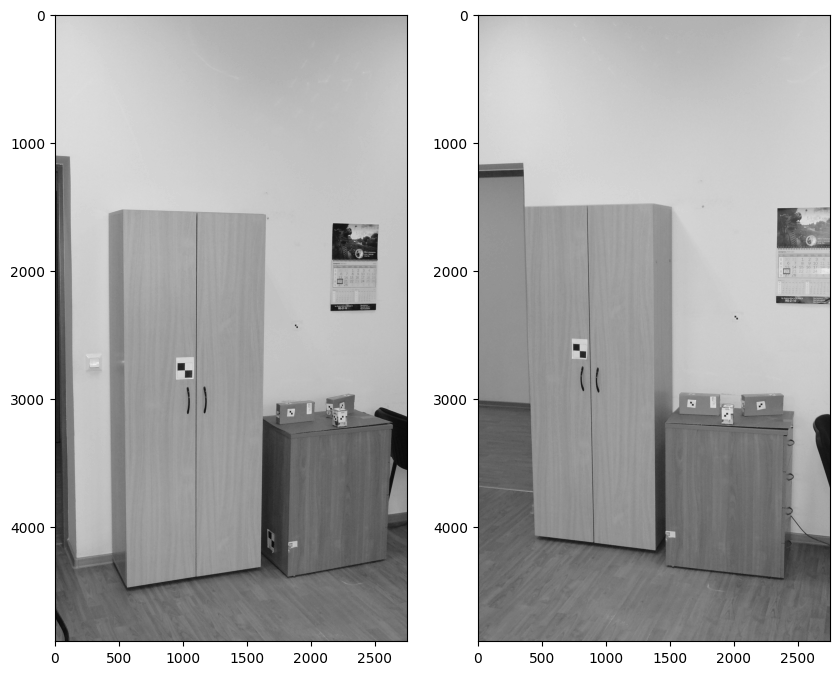

In [11]:
IMG_LEFT_PATH, IMG_RIGHT_PATH = './data/source_images/DSC02694.JPG', './data/source_images/DSC02692.JPG'
image_left, image_right = cv2.imread(IMG_LEFT_PATH, 0), cv2.imread(IMG_RIGHT_PATH, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i, img in enumerate([image_left, image_right]):
    ax[i].imshow(img, 'gray')
plt.show()

### Feature detection, description and matching (using SIFT algorithm with FLANN matcher)

In [12]:
# Initializing SIFT detector
sift = cv2.SIFT_create()

# Detecting keypoints and descriptors using SIFT
# keypoints are distinctive and informative points detected within an image
# descriptors are numerical representations of the local image information surrounding keypoints
kp1, des1 = sift.detectAndCompute(image_left, None)
kp2, des2 = sift.detectAndCompute(image_right, None)

# Match descriptors using FlannBasedMatcher and knnMatch() method with following parameters:
# algorithm = FLANN_INDEX_KDTREE = 1
# used_trees = 5
# checks = 50
matches = cv2.FlannBasedMatcher({'algorithm': 1, 'trees': 5}, {'checks': 50}).knnMatch(des1, des2, k=2)

# If the distance ratio between the best match (m) and the second-best match (n) is less than 0.7, the match is considered good.
left_points, right_points, eps = [], [], 0.7
for match_left, match_right in matches:
    if match_left.distance / match_right.distance < eps:
        left_points.append(kp1[match_left.queryIdx].pt)
        right_points.append(kp2[match_left.trainIdx].pt)
left_points, right_points = np.int32(left_points), np.int32(right_points)

### Computing an essential and fundamental matrices 

In [13]:
# Camera matrix taken from the previous lab
camera_matrix = np.array([[6.053043894903097680e+03, 0.000000000000000000e+00, 2.541066288742518282e+03],
                          [0.000000000000000000e+00, 6.037907735270416197e+03, 1.302932191995148514e+03],
                          [0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]])

# The essential matrix encapsulates the relative pose information between two camera views (using internal parameters of the camera)
essential_matrix = cv2.findEssentialMat(left_points, right_points, camera_matrix)[0]

# The fundamental matrix represents the epipolar geometry between two views. It is computed using points calculated earlier
# cv2.FM_LMEDS (least median of squares) estimation method is used for that
fundamental_matrix = cv2.findFundamentalMat(left_points, right_points, cv2.FM_LMEDS)[0]

### Calculating and drawing epipolar lines

In [14]:
# Calculating epipolar lines on both images (lines in one image that correspond to the projection of points from the other image):
lines_left = cv2.computeCorrespondEpilines(right_points.reshape(-1, 1, 2), 2, F=fundamental_matrix).reshape(-1, 3)
lines_right = cv2.computeCorrespondEpilines(left_points.reshape(-1, 1, 2), 1, F=fundamental_matrix).reshape(-1, 3)

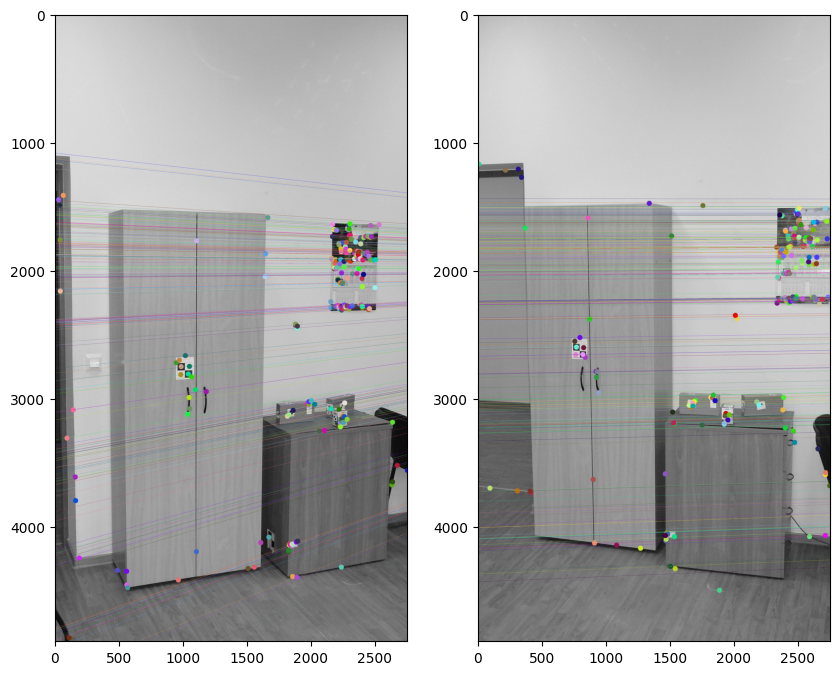

In [15]:
# Drawing epilines and points on images

def drawlines(img, lines, pts):
    r, c = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for r, pt1 in zip(lines, pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img = cv2.line(img, (x0, y0), (x1, y1), color, 1)
        img = cv2.circle(img, tuple(pt1), 20, color, -1)
    return img


fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i, img in enumerate([
    drawlines(image_left, lines_left, left_points),
    drawlines(image_right, lines_right, right_points)
]):
    ax[i].imshow(img)
plt.savefig('data/results/epilines.png')
plt.show()

### Determining projection matrices for both camera views

In [16]:
# Recovering the relative pose between two camera views:
_, rotation_matrix, translation_matrix, _ = cv2.recoverPose(essential_matrix, left_points, right_points, camera_matrix)
# Let's say the first camera is at the origin (rotation is an identity matrix and the last column is about translation (0)), so it's projection_matrix is:
projection_matrix_left = np.dot(camera_matrix, np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]))
# The second camera projection can be found using calculated rotation and translation matrices since the first camera is at the origin:
projection_matrix_right = np.dot(camera_matrix, np.concatenate((rotation_matrix, translation_matrix), axis=1))

### Wardrobe and door bounds defining
<div style="display: flex; justify-content: space-between;">
    <img src="data/images_with_coo/left.png" alt="Image 1"  width="400" height="712">
    <img src="data/images_with_coo/right.png" alt="Image 2"  width="400" height="712">
</div>

In [17]:
wardrobe_left_bounds = np.array([[532, 1528], [563, 4473], [1602, 4313], [1643, 1565]], dtype=np.float32)
door_left_bounds = np.array([[116, 1115], [169, 4315]], dtype=np.float32)
wardrobe_right_bounds = np.array([[363, 1502], [444, 4071], [1383, 4187], [1362, 1478]], dtype=np.float32)
door_right_bounds = np.array([[349, 1163], [425, 3900]], dtype=np.float32)
door_size = 2000  # mm

### Calculating objects' global coordinates and distances between bounds 

In [18]:
# Using projection matrices and wardrobe points we can triangulate corresponding points to obtain global coordinates of door and wardrobe:

def triangulate(pr_matrix_left, pr_matrix_right, left, right):
    result = []
    for lpt, rpt in zip(left, right):
        calc = cv2.triangulatePoints(pr_matrix_left, pr_matrix_right, lpt, rpt)
        result.append(calc[:3] / calc[-1])
    return result


wardrobe_global_coordinates = triangulate(projection_matrix_left, projection_matrix_right, wardrobe_left_bounds,
                                          wardrobe_right_bounds)
wardrobe_global_coordinates

[array([[-0.35647482],
        [ 0.03813309],
        [ 1.0742512 ]], dtype=float32),
 array([[-0.339839 ],
        [ 0.5492159],
        [ 1.0414611]], dtype=float32),
 array([[-0.17898825],
        [ 0.5752873 ],
        [ 1.1538234 ]], dtype=float32),
 array([[-0.17793259],
        [ 0.05083095],
        [ 1.1996318 ]], dtype=float32)]

In [19]:
door_global_coordinates = triangulate(projection_matrix_left, projection_matrix_right, door_left_bounds,
                                      door_right_bounds)
door_global_coordinates

[array([[-0.44834316],
        [-0.03828327],
        [ 1.1197178 ]], dtype=float32),
 array([[-0.420787  ],
        [ 0.54262936],
        [ 1.0764817 ]], dtype=float32)]

In [20]:
# Calculating global distances between points
wardrobe_distances = [cv2.norm(wardrobe_global_coordinates[i - 1], wardrobe_global_coordinates[i]) for i in
                      range(len(wardrobe_global_coordinates))]
door_distance = cv2.norm(door_global_coordinates[0], door_global_coordinates[1])
print(wardrobe_distances)
print(door_distance)

[0.21853801963241193, 0.5124037389452892, 0.1979342393424029, 0.5264541506099956]
0.5831708104402943


### Finally, determining an actual size of a wardrobe

In [21]:
scale = door_size / door_distance
wardrobe_actual = [distance * scale for distance in wardrobe_distances]
wardrobe_actual

[749.4820238599241, 1757.3024224529488, 678.8208044670907, 1805.4886876540422]